In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from math import sqrt
from scipy.optimize import fsolve
import numpy as np
import matplotlib.gridspec as gridspec


### Initialize functions

In [30]:
def generate_covariance(N, eigenvalues, power, debug=False):
    """
    Generates a symmetric, positive semi-definite covariance matrix of size (N, N)
    that is scaled by eigenvalues following a specific power law.

    Args:
    - N (int): Dimensionality of the covariance matrix.
    - eigenvalues (np.ndarray): Eigenvalues of the covariance matrix.

    Returns:
    - sigma (np.ndarray): A symmetric, positive semi-definite covariance matrix of size (N, N).
    """

    # Step 0: Handle the case when power is 0
    if power == 0:
        return np.eye(N)

    # Step 1: Generate a random N * N orthonormal matrix using QR decomposition
    random_matrix = np.random.randn(N, N).astype(np.float64)
    Q, _ = np.linalg.qr(random_matrix)  # Q is orthonormal
    
    # Step 2: Generate a diagonal matrix with the given eigenvalues
    diag = np.diag(eigenvalues)

    # Step 3: Do the reverse operation of Eigenvalue Decomposition
    sigma = Q @ diag @ Q.T
    
    # Optional debugging information
    if debug:
        print(f"Eigenvalues:\n {eigenvalues}")
        print(f"Q:\n {Q}")
        print(f"Diagonal matrix:\n {diag}")
        print(f"Sigma:\n {sigma}")
    
    return sigma

In [31]:
def generate_eigenvalues(N, power):
    """
    Generates eigenvalues for a covariance matrix based on a power spectrum.

    Args:
    - N (int): Number of eigenvalues to generate.
    - power (float): Power of the spectrum, lambda_k = 1 / k^power.

    Returns:
    - eigenvalues (np.ndarray): Array of eigenvalues.
    """
    return np.array([1 / (k + 1)**power for k in range(N)])

In [32]:
def mse(y_true, y_pred, σ, manip=False):
    """
    Computes the mean squared error between the true and predicted values.

    Args:
    - y_true (np.ndarray): True values.
    - y_pred (np.ndarray): Predicted values.
    - σ (float): Noise level.
    - manip (bool): Whether to compute the manipulated mean squared error.
                    Manipulated MSE is defined as 0.5 * (MSE - σ^2).

    Returns:
    - mse (float): Mean squared error.
    """
    error = y_true - y_pred
    mean_error_squared = np.mean(error**2)
    
    return 0.5 * (mean_error_squared - σ ** 2) if manip else mean_error_squared

In [33]:
def generate_w_star(N_max, covariance_matrix, alignment_factor=None, aligned=False):
    '''
    Generates the true weight vector w_star.
    Args:
    - N_max (int): Dimensionality of the weight vector.
    - covariance_matrix (np.ndarray): Covariance matrix used for alignment.
    - alignment_factor (float, optional): Factor to control alignment with the top eigenvector.
    - aligned (bool): If True, w_star is aligned with the top eigenvector of the covariance matrix.
    
    Returns:
    - w_star (np.ndarray): The true weight vector of shape (N_max, 1).
    '''
    if aligned:
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvectors = eigenvectors[:, sorted_indices]
        w_star = eigenvectors[:, 0].reshape(-1, 1)


    else:
        # Generate true weights w_star with squared sum equal to 1
        w_star = np.random.randn(N_max, 1)
    
    # Normalize w_star to have unit norm
    w_star /= np.linalg.norm(w_star)

    return w_star

In [34]:
def calculate_w_hat(X, y, epsilon):
    """
    Calculate the estimated weight vector w_hat using the given formula.

    Args:
    - X (np.ndarray): Feature matrix of size (P, N), where P is the number of samples, and N is the number of features.
    - y (np.ndarray): Target vector of size (P, 1).
    - epsilon (float): Regularization parameter.

    Returns:
    - w_hat (np.ndarray): Estimated weight vector of size (N, 1).
    """
    P = X.shape[0]
    w_hat = np.linalg.inv((X.T @ X)/P + epsilon * np.eye(N)) @ (X.T @ y)/P

    return w_hat


In [35]:
def calculate_gamma(eigenvalues, N, aligned):
    '''
    Calculates gamma for the given covariance matrix and w_star.
    Gamma is defined in equation 11 as:
    sum_k (lambda_k * cos^2(theta_k))

    Args:
    - covariance_matrix (np.ndarray): Covariance matrix of size (N, N).
    - w_star (np.ndarray): True weight vector of size (N, 1).
    - power (float): Power of the spectrum, lambda_k = 1 / k^power.

    Returns:
    - gamma (float): Value of gamma.
    '''
    cos_sq_thetas = np.zeros_like(eigenvalues)
    # Perform eigenvalue decomposition to get eigenvectors
    
    if aligned:
        cos_sq_thetas[0] = 1
    else:
        cos_sq_thetas += 1/N

    gamma = np.sum(eigenvalues * cos_sq_thetas)

    return gamma

In [40]:
def calculate_average_error(P, N, epsilon, eigenvalues, aligned, power, gamma, sigma=1, provide_kappa=None, return_kappa = False):
    """
    Calculate the average generalization error using equation 13.

    Args:
    - P (int): Number of samples.
    - N (int): Number of parameters.
    - epsilon (float): Regularization parameter.
    - eigenvalues (np.ndarray): eigenvalues of the data.
    - w_star (np.ndarray): True weight vector (assumed to be normalized, with L2 norm squared equal to 1).
    - power (int): Power of the eigenvalue spectrum.
    - gamma (float): See eq. 11.
    - sigma (float): Variance of the true noise.
    - provide_kappa (float, optional): If provided, uses this kappa instead of solving for it.
    - return_kappa (bool): If True, returns a tuple of (generalization_error, kappa).

    Returns:
    - float: The average generalization error.
    """

    # Step 1: solve for kappa using equation 16
    alpha = P / N
    if power == 0:

        a = alpha 
        b = alpha - 1 - epsilon * alpha
        c = -epsilon * alpha
        kappa = (sqrt((b) ** 2 - 4 * a * c) - b) / (2 * a)
    
    # If power > 0, we use a numeric solver:
    else:     
        ## Uses old equation 16
        # def equation_to_solve(kappa, alpha, epsilon, eigenvalues):
        #     sum_term = np.sum(eigenvalues / (kappa + eigenvalues))/N
        #     return sum_term + (epsilon * alpha / kappa) - alpha

        ## Uses updated equation 16 with gamma
        def equation_to_solve(kappa, P, epsilon, eigenvalues, gamma):
            sum_term = np.sum(eigenvalues / (kappa + eigenvalues))/P
            return sum_term + (epsilon * gamma / kappa) - 1
                
        # Trying different initial guesses for kappa to find a valid solution
        initial_kappas = range(-30, 10)
        initial_kappas = [10**k for k in initial_kappas]

        # Use solver to find the best approximate value for kappa
        # This part could be designed better to allow for having multiple solutions of kappa and checking
        # which one works best.
        
        for initial_kappa in initial_kappas:
            kappa_solution = fsolve(equation_to_solve, x0=initial_kappa, args=(P, epsilon, eigenvalues, gamma))
            kappa = kappa_solution[0]

            # Check if it solves the equation within an acceptable tolerance (due to precision errors)
            tolerance_check = np.allclose(alpha, np.sum(eigenvalues / (kappa  + eigenvalues))/N + epsilon*alpha / kappa)
            # Check if kappa produces a positive denominator component:
            positivity_check = (1 - (1 / P) * np.sum((eigenvalues**2) / (kappa + eigenvalues)**2)) > 0
            
            if tolerance_check and positivity_check:
                break

        # Raise an error if the final solution is not valid        
        if not tolerance_check:
            print(kappa)
            print(P)
            print(np.sum(eigenvalues / (kappa * gamma + eigenvalues))/N + epsilon*alpha / kappa)
            raise ValueError("The solution for kappa does not satisfy the equation.")
    
        if not positivity_check:
            raise ValueError("The solution for kappa does not produce a positive denominator component.")

    # Insert a provided kappa if it is given
    if provide_kappa is not None:
        kappa = provide_kappa


    # Step 2: Calculate cos^2(theta_k)
    cos_sq_thetas = np.zeros_like(eigenvalues)
    if aligned:      
        cos_sq_thetas[0] = 1
    else:
        cos_sq_thetas += 1/N


    
    # Step 3: Calculate the generalization error using the eq. 13
    # Denominator component (1- DD): 1 - (1 / P) * sum_k (lambda_k^2 / (kappa + lambda_k)^2)
    denominator_component = 1 - ((1 / P) * (np.sum((eigenvalues**2) / (kappa + eigenvalues)**2)))


    # Check if denominator component is positive to avoid division by zero
    if denominator_component == 0:
        # return np.inf
        raise ValueError("Denominator component became equal to zero, indicating a potential error in calculations.")

    # First sum: kappa / gamma * sum_k (kappa * lambda_k * cos^2(theta_k) / (kappa + lambda_k)^2)
    first_sum = 1 / gamma * np.sum((kappa ** 2 * eigenvalues * cos_sq_thetas) / (kappa + eigenvalues) ** 2) 

    # Second sum: (sigma^2 / P) * sum_k (lambda_k^2 / (kappa + lambda_k)^2)
    second_sum = (sigma ** 2 / P) * np.sum((eigenvalues ** 2) / ((kappa + eigenvalues) ** 2)) 

    generalization_error = (1 / 2) * (1 / denominator_component) * (first_sum + second_sum)

    ### Unit tests for the calculation of each element of the equation (for power = 0, see eq. 56):
    alpha_kappa_one = alpha * (kappa + 1) ** 2
    denominator_equivalent = (alpha_kappa_one - 1) / (alpha_kappa_one)
    equivalency_check_denominator = np.isclose(denominator_component, denominator_equivalent)
    if not equivalency_check_denominator and power == 0:
        print(f"denominator_component: {denominator_component}")
        print(f"denominator_equivalent: {denominator_equivalent}")
        raise ValueError("Denominator component does not match the equivalent expression.")
    

    first_sum_equivalent = kappa ** 2 / (gamma * (kappa + 1) ** 2)
    equivalency_check_first_sum = np.isclose(first_sum, first_sum_equivalent)
    if not equivalency_check_first_sum and power == 0:
        print(f"first_sum: {first_sum}")
        print(f"first_sum_equivalent: {first_sum_equivalent}")
        raise ValueError("First sum does not match the equivalent expression.")

    second_sum_equivalent = sigma ** 2 / (alpha * (kappa + 1)**2)
    equivalency_check_second_sum = np.isclose(second_sum, second_sum_equivalent)
    if not equivalency_check_second_sum and power == 0:
        print(f"second_sum: {second_sum}")
        print(f"second_sum_equivalent: {second_sum_equivalent}")
        raise ValueError("Second sum does not match the equivalent expression.")

    generalization_error_equivalent = (1 / 2) * (alpha * kappa ** 2 + sigma ** 2)/ (alpha * (kappa + 1) ** 2 - 1)
    equivalency_check_generalization_error = np.isclose(generalization_error, generalization_error_equivalent)
    if not equivalency_check_generalization_error and power == 0:
        print(f"generalization_error: {generalization_error}")
        print(f"generalization_error_equivalent: {generalization_error_equivalent}")
        raise ValueError("Generalization error does not match the equivalent expression.")
    
    # Return the generalization error (and kappa if requested)
    if not return_kappa:
        return generalization_error  
    else:
        return generalization_error, kappa

### Generate plots

In [79]:
#Low epsilon
#Use less repeats or smaller N for faster computation

N = 1000                # Number of features
P = int(N / 20)         # Initial number of samples
P_max = int(N * 2)      # Maximum number of samples
epsilon = 1e-15         # Regularization parameter
sigma = 1               # Noise variance
repeats = 40

errors = {}
p_range = range(P, P_max + 1, P)
for aligned in [True, False]:
    for power in [0, 1, 2]:    
        for i in tqdm(range(repeats)):
            errors[f"replica_errors_n:{power}_al:{aligned}_{i}"] = []
            errors[f"w_hat_errors_n:{power}_al:{aligned}_{i}"] = []

            eigenvalues = generate_eigenvalues(N, power)
            covariance_matrix = generate_covariance(N, eigenvalues, power)
            w_star = generate_w_star(N, covariance_matrix, aligned=aligned)
            gamma = calculate_gamma(eigenvalues, N, power)

            # Generate synthetic data X from multivariate normal with the generated covariance matrix
            X_train = np.random.multivariate_normal(np.zeros(N), covariance_matrix, size=P_max)

            # Generate noise vectors
            squiggle_train = np.random.normal(0, sigma, (P_max, 1))

            # Generate y labels using the equation "y_mu = w_star dot x_mu + squiggle_mu" 
            y_train = X_train @ w_star + squiggle_train
            for P in p_range:
                
                X_train_subset = X_train[:P, :]
                y_train_subset = y_train[:P, :]

                w_hat_theoretical = np.linalg.inv(X_train_subset.T @ X_train_subset + P * epsilon * np.eye(N)) @ X_train_subset.T @ y_train_subset
                w_hat_theoretical_error = ( (w_hat_theoretical - w_star).T @ covariance_matrix @ (w_hat_theoretical - w_star) )/(2 * gamma)

                #Append the results to the lists
                if i == 0:
                    replica_error = calculate_average_error(P, N, epsilon, eigenvalues,
                                                            aligned, power, gamma, sigma=sigma,
                                                            provide_kappa=None, return_kappa=False)
                    errors[f"replica_errors_n:{power}_al:{aligned}_{i}"].append(replica_error)

                errors[f"w_hat_errors_n:{power}_al:{aligned}_{i}"].append(w_hat_theoretical_error[0][0])

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

C:\Users\Abdo\AppData\Local\Temp\ipykernel_156652\3950848572.py:51: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  kappa_solution = fsolve(equation_to_solve, x0=initial_kappa, args=(P, epsilon, eigenvalues, gamma))


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

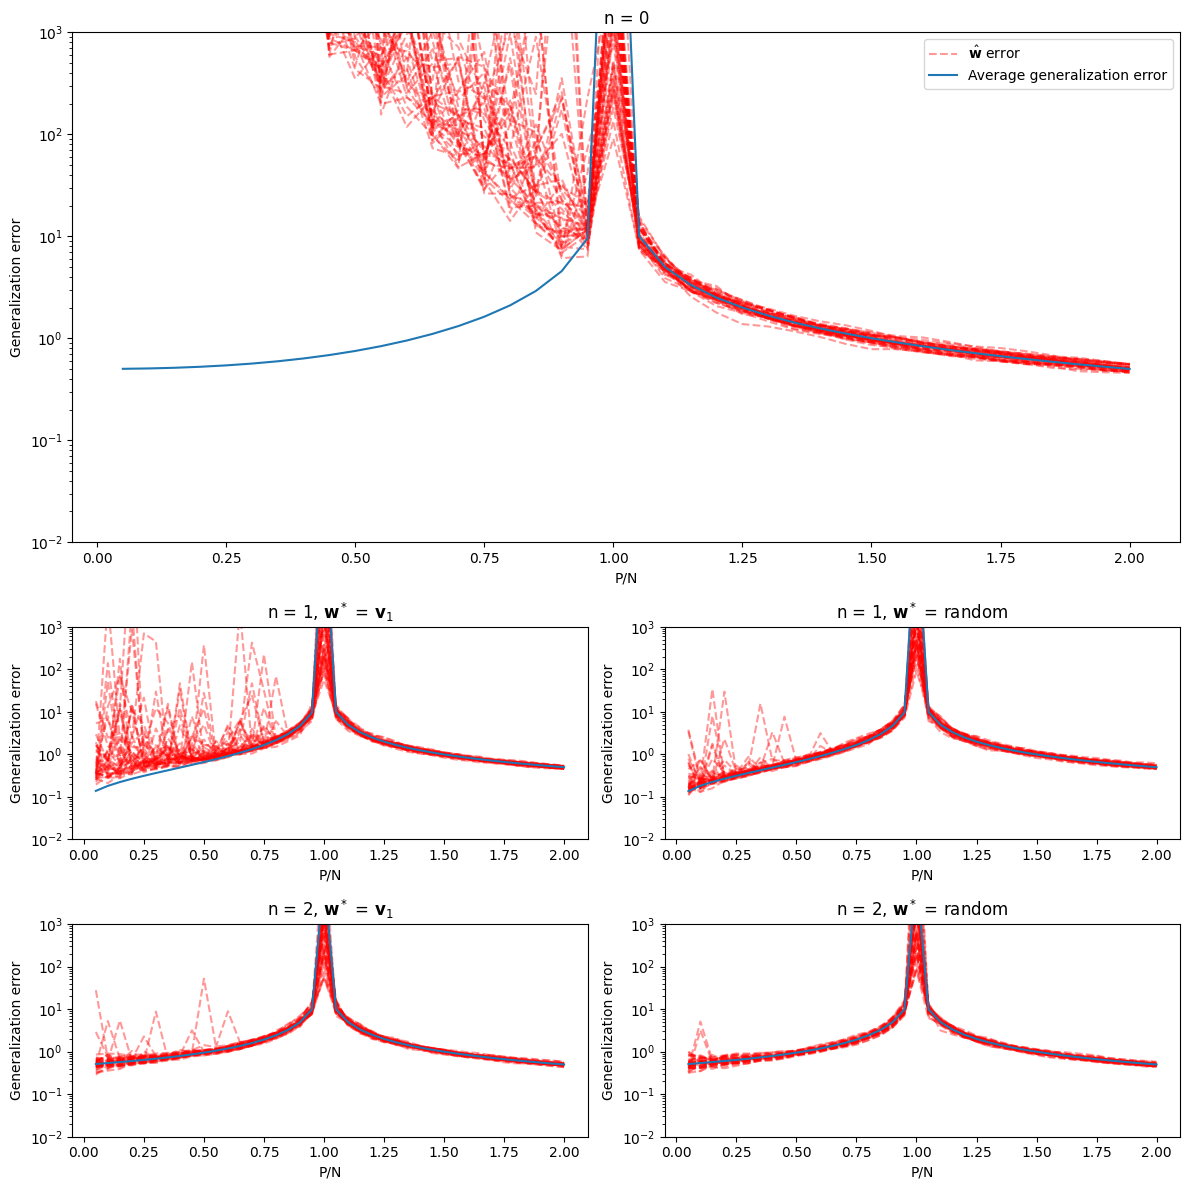

In [86]:
plt.figure(figsize=(12, 12))

# Define a 4×2 grid
gs = gridspec.GridSpec(4, 2, figure=plt.gcf())

j = 4  # grid index starting from 2nd row, since first is special

for power in [0, 1, 2]:
    if power == 0:
        # Centered subplot for power = 0 (span both columns)
        ax = plt.subplot(gs[:2, :])  # first row, spanning both columns
        for i in range(repeats):
            if i == 0:    
                ax.plot(np.array(p_range)/N, errors[f"w_hat_errors_n:{power}_al:{True}_{i}"],
                        label='$\hat{\mathbf{w}}$ error', linestyle='--', color='red', alpha=0.4)
            else:
                ax.plot(np.array(p_range)/N, errors[f"w_hat_errors_n:{power}_al:{True}_{i}"],
                        linestyle='--', color='red', alpha=0.4)
        ax.plot(np.array(p_range)/N, errors[f"replica_errors_n:{power}_al:{True}_{0}"],
                label='Average generalization error')

        ax.set_xlabel('P/N')
        ax.set_ylabel('Generalization error')
        ax.set_yscale('log')
        ax.set_title(f"n = {power}")
        ax.set_ylim(1e-2, 1e3)
        ax.legend()

    else:
        for aligned in [True, False]:
            ax = plt.subplot(gs[j])  # fill the rest of grid cells
            j += 1
            for i in range(repeats):
                if i == 0:    
                    ax.plot(np.array(p_range)/N, errors[f"w_hat_errors_n:{power}_al:{aligned}_{i}"],
                            label='w_hat error', linestyle='--', color='red', alpha=0.4)
                else:
                    ax.plot(np.array(p_range)/N, errors[f"w_hat_errors_n:{power}_al:{aligned}_{i}"],
                            linestyle='--', color='red', alpha=0.4)
            ax.plot(np.array(p_range)/N, errors[f"replica_errors_n:{power}_al:{aligned}_{0}"],
                    label='Average generalization error')

            ax.set_xlabel('P/N')
            ax.set_ylabel('Generalization error')
            ax.set_yscale('log')
            ax.set_ylim(1e-2, 1e3)
            a = "$\mathbf{v}_{1}$" if aligned else "random"
            ax.set_title(f"n = {power}" + ", $\mathbf{w}^*$"+f" = {a}")
            # ax.legend()
plt.tight_layout()
plt.savefig("generalization_error_low_epsilon.png", dpi=300)
plt.show()

In [ ]:
#High epsilon
#Use less repeats or smaller N for faster computation

N = 1000                # Number of features
P = int(N / 20)         # Initial number of samples
P_max = int(N * 2)      # Maximum number of samples
epsilon = 1e-1         # Regularization parameter
sigma = 1               # Noise variance
repeats = 40

errors = {}
p_range = range(P, P_max + 1, P)
for aligned in [True, False]:
    for power in [0, 1, 2]:    
        for i in tqdm(range(repeats)):
            errors[f"replica_errors_n:{power}_al:{aligned}_{i}"] = []
            errors[f"w_hat_errors_n:{power}_al:{aligned}_{i}"] = []

            eigenvalues = generate_eigenvalues(N, power)
            covariance_matrix = generate_covariance(N, eigenvalues, power)
            w_star = generate_w_star(N, covariance_matrix, aligned=aligned)
            gamma = calculate_gamma(eigenvalues, N, power)

            # Generate synthetic data X from multivariate normal with the generated covariance matrix
            X_train = np.random.multivariate_normal(np.zeros(N), covariance_matrix, size=P_max)

            # Generate noise vectors
            squiggle_train = np.random.normal(0, sigma, (P_max, 1))

            # Generate y labels using the equation "y_mu = w_star dot x_mu + squiggle_mu" 
            y_train = X_train @ w_star + squiggle_train
            for P in p_range:
                
                X_train_subset = X_train[:P, :]
                y_train_subset = y_train[:P, :]

                w_hat_theoretical = np.linalg.inv(X_train_subset.T @ X_train_subset + P * epsilon * np.eye(N)) @ X_train_subset.T @ y_train_subset
                w_hat_theoretical_error = ( (w_hat_theoretical - w_star).T @ covariance_matrix @ (w_hat_theoretical - w_star) )/(2 * gamma)

                #Append the results to the lists
                if i == 0:
                    replica_error = calculate_average_error(P, N, epsilon, eigenvalues,
                                                            aligned, power, gamma, sigma=sigma,
                                                            provide_kappa=None, return_kappa=False)
                    errors[f"replica_errors_n:{power}_al:{aligned}_{i}"].append(replica_error)

                errors[f"w_hat_errors_n:{power}_al:{aligned}_{i}"].append(w_hat_theoretical_error[0][0])

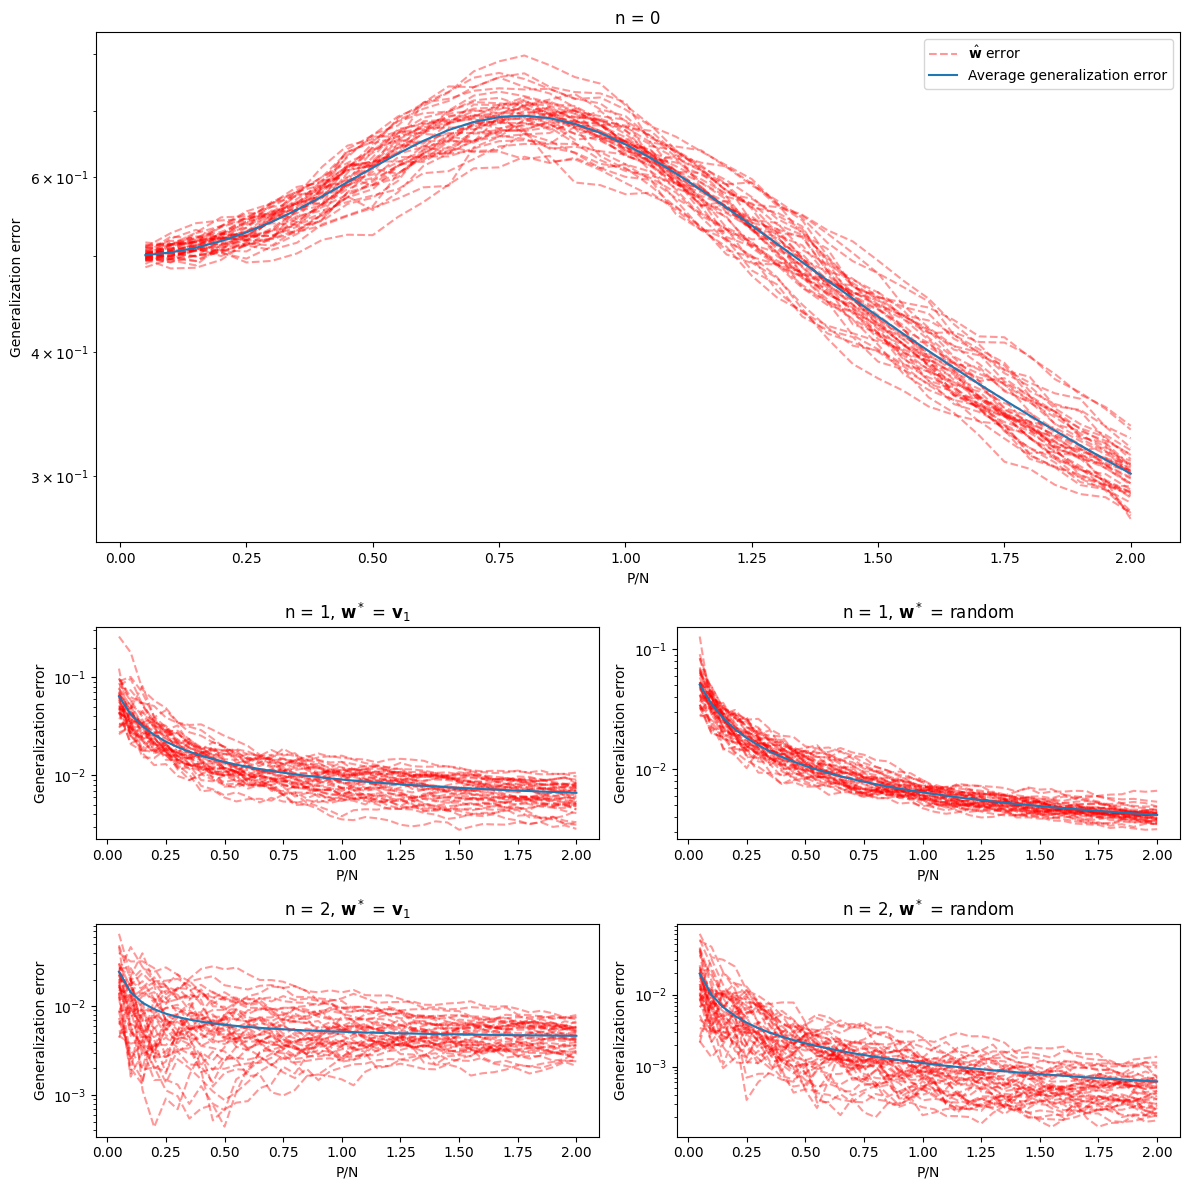

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 12))

# Define a 4×2 grid
gs = gridspec.GridSpec(4, 2, figure=plt.gcf())

j = 4  # grid index starting from 2nd row, since first is special

for power in [0, 1, 2]:
    if power == 0:
        # Centered subplot for power = 0 (span both columns)
        ax = plt.subplot(gs[:2, :])  # first row, spanning both columns
        for i in range(repeats):
            if i == 0:    
                ax.plot(np.array(p_range)/N, errors[f"w_hat_errors_n:{power}_al:{True}_{i}"],
                        label='$\hat{\mathbf{w}}$ error', linestyle='--', color='red', alpha=0.4)
            else:
                ax.plot(np.array(p_range)/N, errors[f"w_hat_errors_n:{power}_al:{True}_{i}"],
                        linestyle='--', color='red', alpha=0.4)
        ax.plot(np.array(p_range)/N, errors[f"replica_errors_n:{power}_al:{True}_{0}"],
                label='Average generalization error')

        ax.set_xlabel('P/N')
        ax.set_ylabel('Generalization error')
        ax.set_yscale('log')
        ax.set_title(f"n = {power}")
        ax.legend()

    else:
        for aligned in [True, False]:
            ax = plt.subplot(gs[j])  # fill the rest of grid cells
            j += 1
            for i in range(repeats):
                if i == 0:    
                    ax.plot(np.array(p_range)/N, errors[f"w_hat_errors_n:{power}_al:{aligned}_{i}"],
                            label='w_hat error', linestyle='--', color='red', alpha=0.4)
                else:
                    ax.plot(np.array(p_range)/N, errors[f"w_hat_errors_n:{power}_al:{aligned}_{i}"],
                            linestyle='--', color='red', alpha=0.4)
            ax.plot(np.array(p_range)/N, errors[f"replica_errors_n:{power}_al:{aligned}_{0}"],
                    label='Average generalization error')

            ax.set_xlabel('P/N')
            ax.set_ylabel('Generalization error')
            ax.set_yscale('log')
            a = "$\mathbf{v}_{1}$" if aligned else "random"
            ax.set_title(f"n = {power}" + ", $\mathbf{w}^*$"+f" = {a}")
            # ax.legend()
plt.tight_layout()
plt.savefig("generalization_error_high_epsilon.png", dpi=300)
plt.show()